I have downloaded this interesting COVID-19 dataset with Canadian COVID cases.
I want to produce a synthetic version to evaluate the El Emam's and Hornby's identification risk scores.

First step is to load the data

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
from sdv.lite import TabularPreset as TP
from sdv.metadata.table import Table
# Create a dict with col names of the dataset and LabelEncoder

ca_covid = pd.read_csv('data/ca_covid.csv')
ca_covid.drop(ca_covid.columns[0:3], inplace=True, axis=1) #Drop id columns



In [3]:

covid_transformers = {}
for column, dt in zip(ca_covid.columns[0:], ca_covid.dtypes[0:]):
    if dt == object:
        covid_transformers[column] = "LabelEncoder"

meta = Table('ca_covid', field_names=ca_covid.columns.to_list(),
             field_transformers=covid_transformers)
meta.fit(ca_covid)



In [9]:
ca_transformed = meta.transform(ca_covid)


,health_region,age_group,gender,exposure,case_status,latitude,longitude,province,province_abbr,hr_uid
1253786,Montréal,Not Reported,Not Reported,Not Reported,Not Reported,45.542072,-73.605668,Quebec,QC,2406.0
1264727,Montréal,Not Reported,Not Reported,Not Reported,Not Reported,45.542072,-73.605668,Quebec,QC,2406.0
1001076,Capitale-Nationale,Not Reported,Not Reported,Not Reported,Not Reported,47.422683,-71.283095,Quebec,QC,2403.0
103946,Durham Region Health Department,60-69,Male,Close Contact,Recovered,44.035150,-78.882498,Ontario,ON,3530.0
251323,Toronto Public Health,20-29,Female,Not Reported,Recovered,43.725845,-79.389558,Ontario,ON,3595.0
737354,Calgary Zone,20-29,Female,Not Reported,Recovered,50.988415,-114.283168,Alberta,AB,4832.0
779259,Calgary Zone,<20,Male,Not Reported,Recovered,50.988415,-114.283168,Alberta,AB,4832.0
795701,Calgary Zone,40-49,Female,Not Reported,Recovered,50.988415,-114.283168,Alberta,AB,4832.0
15829,Windsor-Essex County Health Unit,<20,Male,Close Contact,Recovered,42.156423,-82.777533,Ontario,ON,3568.0
907393,Edmonton Zone,Not Reported,Male,Not Reported,Recovered,53.572970,-113.539689,Alberta,AB,4834.0


I want to demonstrate the how to use Gaussian Copulas from SDV

In [4]:
from sdv.tabular import GaussianCopula

Now to build the model. I use truncated gaussian as the default copula distribution and encode all the categorical variables as labels.

In [11]:
generator = GaussianCopula( table_metadata=meta,
                            default_distribution='truncated_gaussian')
generator.fit(ca_covid)

c:\Users\wxqg\.virtualenvs\sdv-V2IxAAAW\lib\site-packages\copulas\univariate\truncated_gaussian.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  a = (self.min - loc) / scale
c:\Users\wxqg\.virtualenvs\sdv-V2IxAAAW\lib\site-packages\copulas\univariate\truncated_gaussian.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  b = (self.max - loc) / scale


In [7]:
generator.sample(10)

,health_region,age_group,gender,exposure,case_status,latitude,longitude,province,province_abbr,hr_uid
0,Lambton Public Health,<20,Male,Travel-Related,Recovered,44.788057,-83.984203,Ontario,ON,3545.0
1,"Haliburton, Kawartha, Pine Ridge District Heal...",80+,Male,Close Contact,Active,42.546686,-60.631092,British Columbia,BC,827.0
2,Laval,70-79,Not Reported,Not Reported,Not Reported,49.299885,-99.326974,Saskatchewan,SK,1368.0
3,Southwestern Public Health,80+,Male,Not Reported,Deceased,43.439512,-66.822850,British Columbia,BC,2934.0
4,Brant County Health Unit,30-39,Male,Not Reported,Recovered,44.572850,-100.717542,Alberta,AB,5661.0
5,Hamilton Public Health Services,<20,Male,Travel-Related,Deceased,44.971267,-71.167057,British Columbia,BC,3474.0
6,Out of Canada,40-49,Male,Outbreak,Active,49.123100,-89.052593,Alberta,AB,3586.0
7,Gaspésie-Îles-de-la-Madeleine,50-59,Male,Travel-Related,Active,53.077155,-96.413580,Saskatchewan,SK,3075.0
8,Lambton Public Health,50-59,Female,Not Reported,Deceased,46.459904,-77.583919,British Columbia,BC,3623.0
9,Toronto Public Health,20-29,Female,Close Contact,Recovered,43.875039,-95.780872,Ontario,ON,3669.0


Due to the size of the model, we shall do the sampling in batches to avoid peak memory issues.
In general it seems that SDV is quite memory hungry.

In [15]:
generator.sample(100000).to_csv('data/ca_covid_synth.csv', mode='w')
for _ in range(1,11):
    generator.sample(100000).to_csv('data/ca_covid_synth.csv', mode='a', header=False)

And we are done! It was that easy to generate a dataset using Gaussian Copulas.

Wait, actually we really want to be able to find the probability of obtaining a given row from the COPULA.
This will help us when we want to show that we are unlikely to sample real patients from our model


In [13]:
n_samples = 10000
sampled_likelihood = generator.get_likelihood(generator.sample(n_samples))
sampled_likelihood = pd.DataFrame({"likelihood": sampled_likelihood, "type": ['COPULA'] * n_samples})
ca_covid_likelihood = generator.get_likelihood(ca_covid.sample(n_samples))
ca_covid_likelihood = pd.DataFrame({"likelihood": ca_covid_likelihood, "type": ['ORIGINAL'] * n_samples})

likelihoods = pd.concat([ca_covid_likelihood, sampled_likelihood], ignore_index=True)

In [23]:
import seaborn as sb


Now we can plot the likelyhood of generating real samples from the COPULA-model and compare it to the likelyhood of the synthetic samples.

<AxesSubplot: xlabel='type', ylabel='likelihood'>

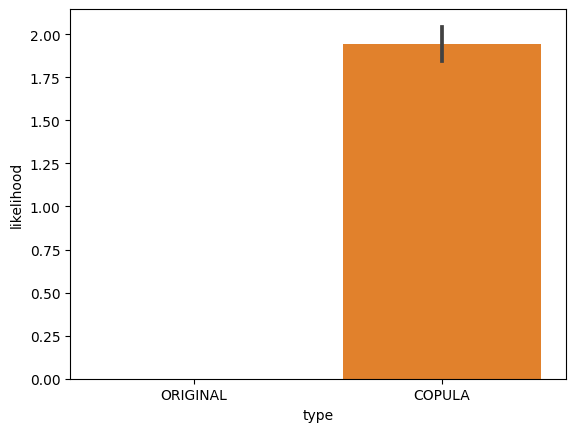

In [44]:
sb.barplot(data=likelihoods, y="likelihood", x="type")

As is evident, we do not have to worry about sampling real patient using this COPULA-model!
But how do the data distributions look?

NameError: name 'n' is not defined

In [38]:
synth = generator.sample(10000)
real  = ca_covid.sample(10000)
synth["type"] = "COPULA"
real["type"] = "REAL"
factor_dataset = pd.concat([synth, real], ignore_index=True)
#factor_dataset = pd.melt(factor_dataset, id_vars="type", value_vars=[n for n in factor_dataset.iloc[:, factor_dataset.columns != 'type']])

<AxesSubplot: xlabel='health_region', ylabel='Count'>

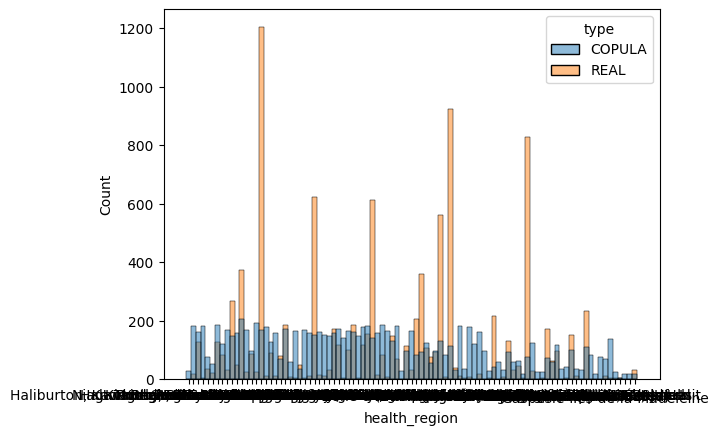

In [41]:
sb.histplot(factor_dataset, x="health_region", hue="type")

<AxesSubplot: xlabel='gender', ylabel='Count'>

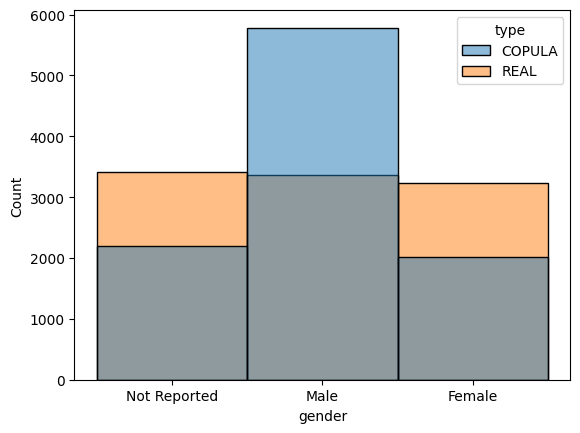

In [42]:
sb.histplot(factor_dataset, x="gender", hue="type")

<AxesSubplot: xlabel='exposure', ylabel='Count'>

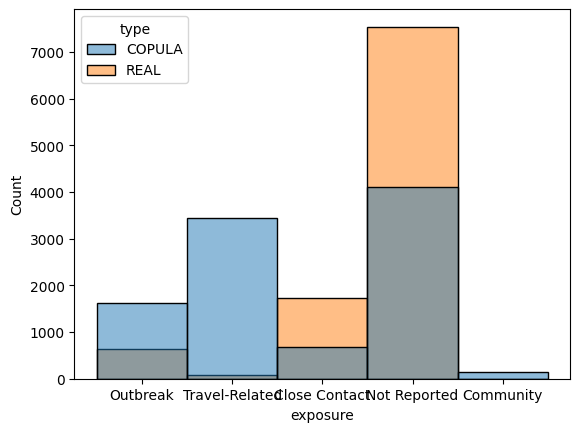

In [43]:
sb.histplot(factor_dataset, x="exposure", hue="type")

<AxesSubplot: xlabel='case_status', ylabel='Count'>

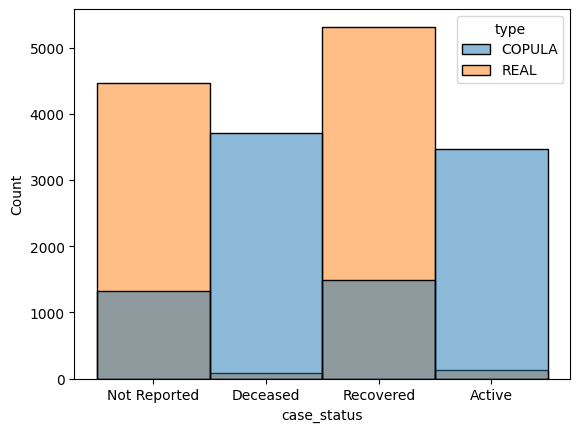

In [44]:
sb.histplot(factor_dataset, x="case_status", hue="type")

<AxesSubplot: xlabel='latitude', ylabel='longitude'>

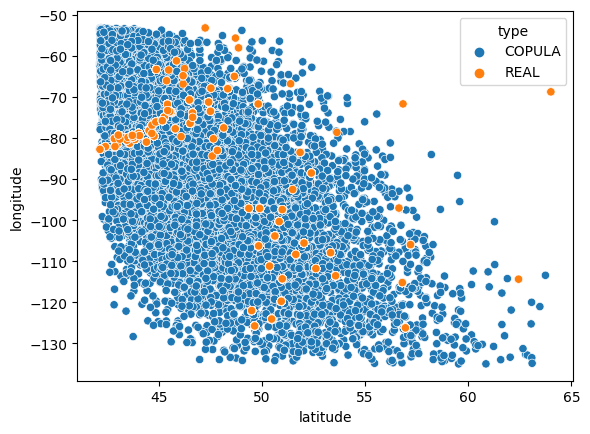

In [46]:
sb.scatterplot(factor_dataset, x="latitude", y="longitude", hue="type")

<AxesSubplot: xlabel='province', ylabel='Count'>

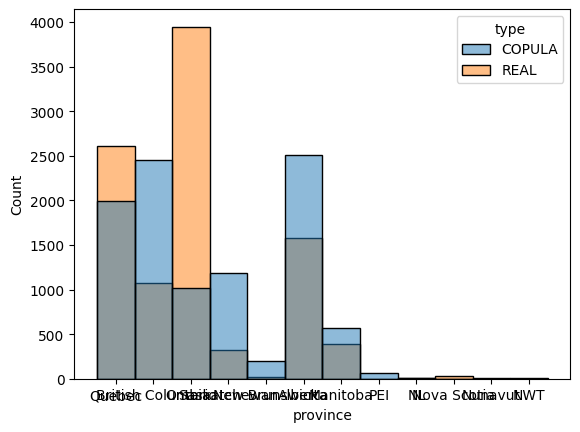

In [47]:
sb.histplot(factor_dataset, x="province", hue="type")